## Explore Marginal and Captial Cost of Power Plants


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa

import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
import sys
from textwrap import wrap
import random
%matplotlib inline
pd.options.display.max_columns = None

In [3]:
# basic setup for logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

### Prep the EIA and FERC Data

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
start_date=None
end_date=None
freq='AS'

In [5]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS',rolling=True)

In [6]:
def grab_renew_cost():
    renew_costs_lbl = (
        pd.read_excel(
            'https://emp.lbl.gov/sites/default/files/2018_wtmr_data_file.xlsx', 
            sheet_name='Figure 56',skiprows=6,)
        .rename(columns={'Unnamed: 0':'report_year',
                         '2018 $/MWh':'price_gas_per_mwh',
                         '2018 $/MWh.1':'price_solar_per_mwh',
                         '2018 $/MWh.2':'price_wind_per_mwh'}, ))
    return renew_costs_lbl

In [7]:
def prep_mcoe_eia(pudl_out):
    mcoe_eia = pudl_out.mcoe()
    mcoe_eia = mcoe_eia.assign(
        report_year = mcoe_eia.report_date.dt.year,
        fuel_cost = mcoe_eia.fuel_cost_per_mwh * mcoe_eia.net_generation_mwh)
    mcoe_grouped = (
        mcoe_eia.groupby(by=['report_year','plant_id_pudl',])
        .agg({'capacity_mw':'sum',
              'fuel_cost_per_mwh': 'mean',
              'fuel_cost': 'sum',
              'net_generation_mwh': 'sum'
             })
        .reset_index()
    )
    return mcoe_grouped

In [8]:
def get_non_fuel_cols(pudl_out):
    steam_ferc1 = pudl_out.plants_steam_ferc1()
    # add in a non-fuel opex column
    fuel_total_cols = ['opex_fuel','opex_production_total',
                       'opex_per_mwh','opex_nonfuel_per_mwh', 'opex_fuel_per_mwh']
    opex_non_fuel_total_cols = [x for x in steam_ferc1.filter(like='opex').columns 
                                if x not in fuel_total_cols]
    return opex_non_fuel_total_cols

In [9]:
def grab_steam_ferc1(pudl_out):
    steam_ferc1 = pudl_out.plants_steam_ferc1()
    opex_non_fuel_total_cols = get_non_fuel_cols(pudl_out)
    steam_ferc1 = (
        steam_ferc1.assign(
            opex_non_fuel_total=steam_ferc1[opex_non_fuel_total_cols].sum(axis=1),
            capex_total_calc=steam_ferc1[['capex_land','capex_structures','capex_equipment']].sum(axis=1),
        )
    )
    return steam_ferc1

In [10]:
def prep_mcoe_ferc(pudl_out):
    steam_grouped = (
        grab_steam_ferc1(pudl_out)
        .groupby(by=['plant_id_pudl','report_year']).sum()
        .reset_index()
    )
    return steam_grouped

In [11]:
def add_plant_info(pudl_out, mcoe_ferc_eia):
    # plant-level info 
    plants = pudl_out.plants_eia860()
    info_cols = ['plant_id_pudl', 'state', 'report_date','plant_name_eia']
    plants= (plants[info_cols]
             .drop_duplicates()
             .assign(report_year=plants.report_date.dt.year)
             .drop(columns=['report_date']))

    plants_f1 = pudl_out.plants_steam_ferc1()

    # merge in plant-level data
    mcoe_ferc_eia = (
        pd.merge(mcoe_ferc_eia,plants,)
        .merge(plants_f1[['plant_name_ferc1','plant_id_pudl']].drop_duplicates(subset='plant_id_pudl'))
    )
    mcoe_ferc_eia.plant_name_eia = mcoe_ferc_eia.plant_name_eia.fillna(value=mcoe_ferc_eia.plant_name_ferc1)
    return mcoe_ferc_eia

In [12]:
def assign_mcoe_calcs(mcoe_ferc_eia):
    mcoe_ferc_eia = mcoe_ferc_eia.assign(
        opex=mcoe_ferc_eia[['opex_non_fuel_total','fuel_cost',]].sum(axis=1))
    mcoe_ferc_eia = mcoe_ferc_eia.assign(
        opex_per_mwh=mcoe_ferc_eia.opex / mcoe_ferc_eia.net_generation_mwh_eia,
        fuel_cost_per_mwh_calc=mcoe_ferc_eia.fuel_cost / mcoe_ferc_eia.net_generation_mwh_eia,
        fuel_cost_per_mwh_ferc1=mcoe_ferc_eia.opex_fuel / mcoe_ferc_eia.net_generation_mwh_ferc,
        opex_non_fuel_per_mwh=mcoe_ferc_eia.opex_non_fuel_total / mcoe_ferc_eia.net_generation_mwh_ferc,
        capex_per_mw=mcoe_ferc_eia.capex_total/mcoe_ferc_eia.capacity_mw_ferc,
    )
    mcoe_ferc_eia = mcoe_ferc_eia.assign(
        fuel_cost_per_mwh= mcoe_ferc_eia.fuel_cost_per_mwh.fillna(mcoe_ferc_eia.fuel_cost_per_mwh_ferc1),)

    mcoe_ferc_eia['fuel_cost_test'] = (mcoe_ferc_eia.fuel_cost_per_mwh_calc.round(decimals=0) 
                                       == mcoe_ferc_eia.fuel_cost_per_mwh.round(decimals=0))
    logging.debug(len(mcoe_ferc_eia[(~mcoe_ferc_eia.fuel_cost_test) &
                  (mcoe_ferc_eia._merge != 'left_only')]))
    return mcoe_ferc_eia

In [13]:
def prep_mcoe_eia_ferc(pudl_out):
    mcoe_ferc_eia = pd.merge(prep_mcoe_ferc(pudl_out),prep_mcoe_eia(pudl_out),
                             on=['plant_id_pudl','report_year'], 
                             how='outer',
                             indicator=True,
                             suffixes=('_ferc','_eia')
                            )
    mcoe_ferc_eia = assign_mcoe_calcs(mcoe_ferc_eia)
    mcoe_ferc_eia = add_plant_info(pudl_out, mcoe_ferc_eia)
    logger.info(f'We have MCOE data for {len(mcoe_ferc_eia.state.unique())} states!')
    logger.info(
        'We dont have data for the following states:'
        f'{[x for x in pc.us_states.keys()if x not in mcoe_ferc_eia.state.unique()]}')
    return mcoe_ferc_eia

### Generate the Dataframes

In [14]:
renew_costs_lbl = grab_renew_cost()
mcoe_ferc_eia = prep_mcoe_eia_ferc(pudl_out)

filling in fuel cost NaNs with rolling averages
We have MCOE data for 43 states!
We dont have data for the following states:['AS', 'CT', 'DC', 'DE', 'GU', 'HI', 'MP', 'NA', 'NE', 'NJ', 'PR', 'RI', 'TN', 'VI']


### Plot the Plottzz

In [15]:
figsize=(12,5)
mpl.style.use('dark_background')

def grab_mcoe_state_year(mcoe_ferc_eia, state, year):
    return (mcoe_ferc_eia[(mcoe_ferc_eia.report_year == year)
                         & (mcoe_ferc_eia.state == state)
                         & (mcoe_ferc_eia.capacity_mw_eia.notnull())
                         & (mcoe_ferc_eia.fuel_cost_per_mwh > 0)
                         & (mcoe_ferc_eia.opex_non_fuel_per_mwh > 0)
                        ]
            .drop_duplicates(subset=['plant_name_eia'])
            .sort_values(by='capacity_mw_eia', ascending=False))

def grab_mcoe_plant(mcoe_ferc_eia, plant_name):
    return (mcoe_ferc_eia[mcoe_ferc_eia['plant_name_eia'] == plant_name]
            .drop_duplicates(subset=['plant_name_eia','report_year']))

def plot_mcoe_state_year(mcoe_ferc_eia, renew_costs_lbl, state, year, renew=False):
    mcoe_year = grab_mcoe_state_year(mcoe_ferc_eia, state, year)
    
    if mcoe_year.empty:
        logger.info(f'No plants for {year} in {state}')
        return
    plant_names = mcoe_year.plant_name_eia
    plant_names = ['\n'.join(wrap(name,12)) for name in plant_names]
    variable_om_mwh = mcoe_year.opex_non_fuel_per_mwh
    fuel_cost_mwh = mcoe_year.fuel_cost_per_mwh
    width = 0.35       # the width of the bars: can also be len(x) sequence

    if len(plant_names) > 8:
        plt.rcParams.update({'font.size': 8, 'font.weight' : 'bold',})
    else: 
        plt.rcParams.update(
            {'font.size': 15, 'font.weight' : 'bold',})
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(plant_names, fuel_cost_mwh, label='Fuel Cost',color='mediumslateblue')
    ax.bar(plant_names, variable_om_mwh, bottom=fuel_cost_mwh, 
           label='Non-Fuel Operational Costs', color='turquoise')
    
    rects = ax.patches
    # Make some labels.
    labels = list(mcoe_year.capacity_mw_eia.astype(int))
    labels = [str(x) + " MW" for x in labels]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, 1, label,ha='center', va='bottom')

    if renew:
        wind = renew_costs_lbl.loc[renew_costs_lbl['report_year'] == year, 'price_wind_per_mwh'].values[0].round(2)
        solar = renew_costs_lbl.loc[renew_costs_lbl['report_year'] == year, 'price_solar_per_mwh'].values[0].round(2)
        xmin, xmax = plt.xlim()
        plt.axhline(wind,color = 'silver',lw=3)
        plt.text(xmin+.5, wind+(xmax*.15), f'Average US Wind: ${wind}/MWh',{'fontsize': 12}, color='silver')

        plt.axhline(solar,color = 'lemonchiffon',lw=3)
        plt.text(xmin+.5, solar+(xmax*.15), f'Average US Solar: ${solar}/MWh',{'fontsize': 12}, color='lemonchiffon')

        
    ax.set_ylabel('$/MWh')
    ax.set_title(f'Operational Costs for {state} Plants in {year}',
                 {'fontsize': 18,'fontweight' : 'bold'})
    ax.legend()
    plt.show()
    
def plot_plant_over_time(mcoe_ferc_eia, renew_costs_lbl, plant_name, renew=False):
    mcoe_plant = grab_mcoe_plant(mcoe_ferc_eia, plant_name)
    plt.figure(figsize=figsize)
    df = mcoe_plant.sort_values('report_year')
    plt.stackplot(
        df['report_year'],
        df['fuel_cost_per_mwh'],
        df['opex_non_fuel_per_mwh'],
        labels=('Fuel Cost', 'Variable O&M'),
        colors = ['mediumslateblue', 'turquoise',],
    )
    
    if renew:
        plt.plot(renew_costs_lbl['report_year'],renew_costs_lbl['price_wind_per_mwh'],color='silver', lw=3, label='Wind')
        plt.plot(renew_costs_lbl['report_year'],renew_costs_lbl['price_solar_per_mwh'],color='lemonchiffon', lw=3, label='Solar')
    plt.xlim(left=2009,right=2018)
    plt.ylabel('$/MWh')
    plt.legend()
    plt.title(f'Operational Costs for {plant_name}', 
              {'fontsize': 18,'fontweight' : 'bold'})
    plt.show()

def plot_cap_cost(mcoe_ferc_eia, plant_name):
    mcoe_plant = grab_mcoe_plant(mcoe_ferc_eia, plant_name)
    plt.figure(figsize=figsize)
    df = mcoe_plant.sort_values('report_year')

    plt.stackplot(
        df['report_year'],
        df['capex_land'],
        df['capex_structures'],
        df['capex_equipment'],
        labels=('Land','Structures','Equipment',),
        colors = ['darkolivegreen','mediumseagreen','aquamarine'],
    )

    plt.legend()
    plt.ylabel('Captial Cost ($)')
    plt.title(f'Capital Costs for {plant_name}')
    plt.show()

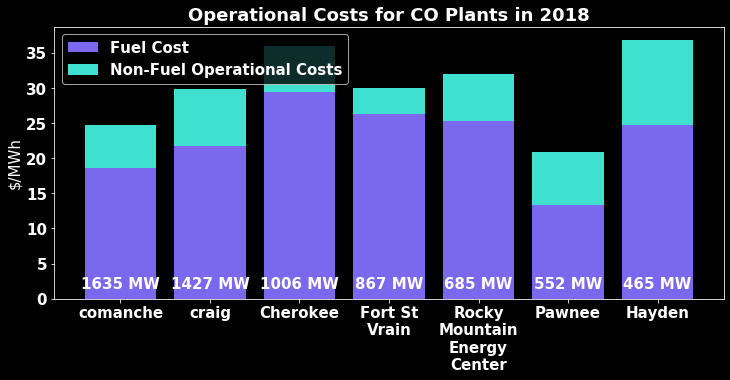

In [16]:
plot_mcoe_state_year(mcoe_ferc_eia, renew_costs_lbl, state='CO', year=2018, renew=False,)

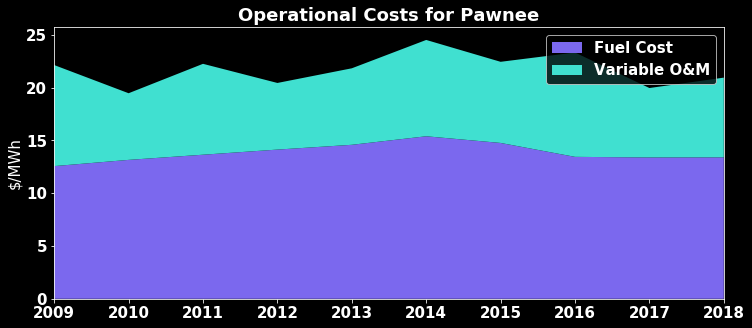

In [17]:
plot_plant_over_time(mcoe_ferc_eia, renew_costs_lbl, plant_name = 'Pawnee',renew=False)

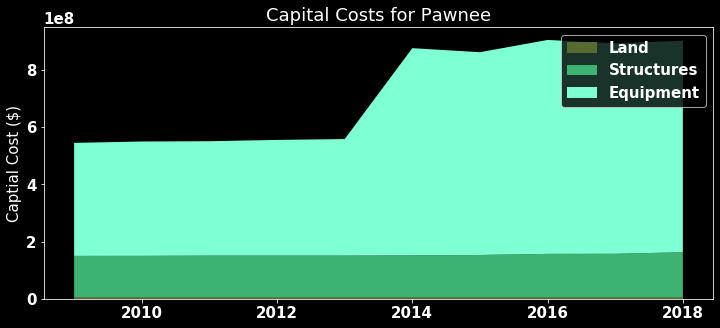

In [18]:
plot_cap_cost(mcoe_ferc_eia, 'Pawnee')

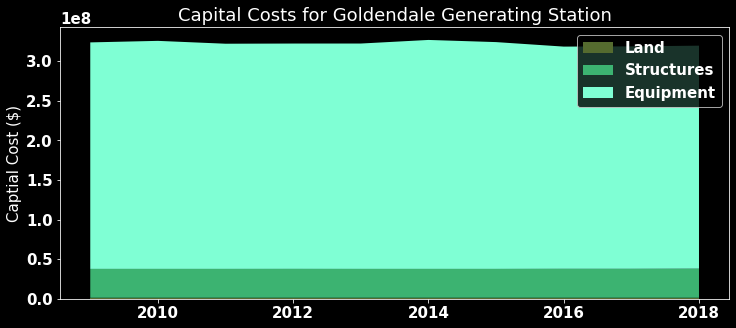

In [22]:
plot_cap_cost(mcoe_ferc_eia, mcoe_ferc_eia.loc[random.randint(0,len(mcoe_ferc_eia)),'plant_name_eia'])

In [20]:
#for state in pc.us_states.keys():
#    plot_mcoe_state_year(mcoe_ferc_eia, renew_costs_lbl, state=state, year=2018,renew=True)

#### Breakdown of non-fuel operational costs

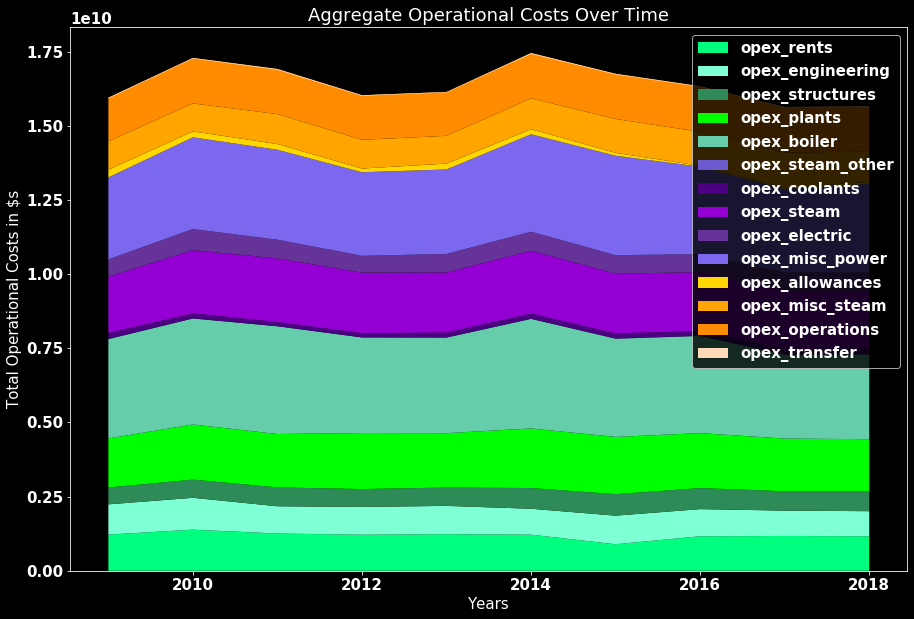

In [21]:
df = mcoe_ferc_eia.groupby(by=['report_year']).sum().reset_index().sort_values('report_year')

opex_non_fuel_total_cols = get_non_fuel_cols(pudl_out)
fixed_cols = ["opex_rents", "opex_engineering", "opex_structures", "opex_plants",'opex_boiler',]
variable = ["opex_steam_other", "opex_coolants", "opex_steam", "opex_electric","opex_misc_power"]
who_knows = [x for x in opex_non_fuel_total_cols if x not in fixed_cols + variable]
opex_sorted = fixed_cols + variable + who_knows

cols_to_plot = []
for col in opex_sorted:
    cols_to_plot.append(df[col])

# colors
fixed_clrs = ['springgreen','aquamarine','seagreen','lime','mediumaquamarine']
variable_clrs = ['slateblue','indigo','darkviolet','rebeccapurple','mediumslateblue']
who_clrs = ['gold','orange','darkorange','peachpuff']


plt.figure(figsize=(15,10))
plt.stackplot(
    df['report_year'],
    cols_to_plot,
    labels=opex_sorted,
    colors = fixed_clrs+variable_clrs+who_clrs,
)
plt.legend()
plt.title(f'Aggregate Operational Costs Over Time')
plt.ylabel('Total Operational Costs in $s')
plt.xlabel('Years')
plt.show()